In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Aug 21 13:19:08 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
#mounting google drive on colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Importing the libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import copy


# Importing the Keras libraries and packages
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout

In [ ]:
X_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_trainv7_exp1_strat.npy")
y_train=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_trainv7_exp1_strat.npy").astype(int)

X_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_X_testv7_exp1_strat.npy")
y_test=np.load("./drive/MyDrive/MSc Thesis/Experiments/all_pairs_ts_data_y_testv7_exp1_strat.npy").astype(int)


In [ ]:
def custom_scaler(X, range=(0, 1),min=None,max=None):
    mi, ma = range
    if(min==None):
      min=X.min()
      max=X.max()
      print("\nTrain_Scaling:- min=",min," max=",max)
    X_std = (X - min) / (max - min)
    X_scaled = X_std * (ma - mi) + mi
    return min,max,X_scaled

In [ ]:
print(X_train.shape)
print(X_test.shape)

(21256, 50, 4)
(2798, 50, 4)


In [ ]:
# Feature Scaling
#X_train contains 8 signals x1,x2,y1,y2
X_train_scaled=copy.copy(X_train)
X_test_scaled=copy.copy(X_test)

min_temp,max_temp,X_train_scaled[:,:,0:2]=custom_scaler(X_train_scaled[:,:,0:2],range=(0,1))
_,_,X_test_scaled[:,:,0:2]=custom_scaler(X_test_scaled[:,:,0:2],range=(0,1),min=min_temp,max=max_temp)

min_temp,max_temp,X_train_scaled[:,:,2:4]=custom_scaler(X_train_scaled[:,:,2:4],range=(0,1))
_,_,X_test_scaled[:,:,2:4]=custom_scaler(X_test_scaled[:,:,2:4],range=(0,1),min=min_temp,max=max_temp)


Train_Scaling:- min= -23.713684702675817  max= 31.485281374238568

Train_Scaling:- min= -24.82483202959873  max= 27.77992367859456


In [ ]:
# Part 2 - Building the LSTM

# Initialising the LSTM
classifier = Sequential()

# Adding the first LSTM layer and some Dropout regularisation
classifier.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])))

# Adding a second LSTM layer and some Dropout regularisation
classifier.add(LSTM(units = 50))

# Adding the output layer
classifier.add(Dense(units = 1,activation='sigmoid'))

# Compiling the LSTM
classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])


In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

checkpoint = ModelCheckpoint("./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_baseline_exp1_strat_v2.h5",
                             monitor="val_accuracy",
                             mode="max",
                             save_best_only = True,
                             verbose=1)


earlystop = EarlyStopping(monitor = 'val_accuracy', # value being monitored for improvement
                          min_delta = 0, #Abs value and is the min change required before we stop
                          patience = 20, #Number of epochs we wait before stopping 
                          verbose = 1,
                          restore_best_weights = True) #keeps the best weigths once stopped

# we put our call backs into a callback list
callbacks = [earlystop,checkpoint]


In [ ]:
# Fitting the RNN to the Training set
history=classifier.fit(X_train_scaled, y_train[:,0], epochs = 200, batch_size = 64,validation_data=(X_test_scaled,y_test[:,0]),callbacks=callbacks)


Epoch 1/200
328/333 [============================>.] - ETA: 0s - loss: 0.5247 - accuracy: 0.7278
Epoch 1: val_accuracy improved from -inf to 0.80629, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_baseline_exp1_strat_v2.h5
333/333 [==============================] - 11s 11ms/step - loss: 0.5234 - accuracy: 0.7288 - val_loss: 0.3910 - val_accuracy: 0.8063
Epoch 2/200
327/333 [============================>.] - ETA: 0s - loss: 0.3885 - accuracy: 0.8055
Epoch 2: val_accuracy improved from 0.80629 to 0.84024, saving model to ./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_baseline_exp1_strat_v2.h5
333/333 [==============================] - 3s 8ms/step - loss: 0.3885 - accuracy: 0.8056 - val_loss: 0.3447 - val_accuracy: 0.8402
Epoch 3/200
333/333 [==============================] - ETA: 0s - loss: 0.4065 - accuracy: 0.7895
Epoch 3: val_accuracy did not improve from 0.84024
333/333 [==============================] - 3s 8ms/step - loss: 0.4065 - accuracy: 0.7895 - val_loss

In [ ]:
classifier.evaluate(X_test_scaled,y_test[:,0])

88/88 [==============================] - 0s 4ms/step - loss: 0.2670 - accuracy: 0.8828


[0.26701968908309937, 0.8827733993530273]

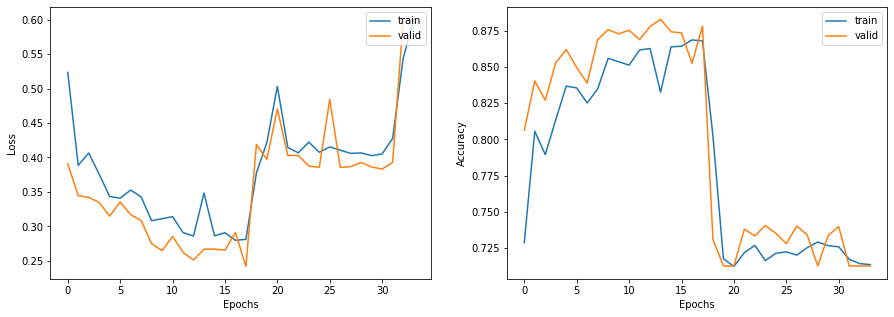

In [ ]:
import matplotlib.pyplot as plt
def display_learning_curves(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    ax1.plot(history.history["loss"])
    ax1.plot(history.history["val_loss"])
    ax1.legend(["train", "valid"], loc="upper right")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")

    ax2.plot(history.history["accuracy"])
    ax2.plot(history.history["val_accuracy"])
    ax2.legend(["train", "valid"], loc="upper right")
    ax2.set_xlabel("Epochs")
    ax2.set_ylabel("Accuracy")
    plt.show()

display_learning_curves(history)

In [ ]:
import tensorflow as tf
temp=tf.keras.models.load_model("./drive/MyDrive/MSc Thesis/Experiments/models/LSTM_baseline_exp1_strat_v2.h5")

In [ ]:
temp.evaluate(X_test_scaled, y_test[:,0], 1)

2798/2798 [==============================] - 10s 3ms/step - loss: 0.2670 - accuracy: 0.8828


[0.26701951026916504, 0.8827733993530273]

In [ ]:
y_pred = temp.predict(X_test_scaled)
y_pred= (y_pred>=0.5).astype(int)

In [ ]:
print(X_test_scaled.shape)
temp.predict(X_test_scaled)

(2798, 50, 4)


array([[8.2523882e-01],
       [1.2147739e-03],
       [8.9853932e-04],
       ...,
       [9.2420608e-01],
       [8.3439571e-01],
       [1.9279471e-01]], dtype=float32)

In [ ]:
y_pred

array([[1],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
from sklearn.metrics import accuracy_score, f1_score, classification_report,confusion_matrix

In [ ]:
confusion_matrix(y_test[:,0],y_pred)

array([[1789,  205],
       [ 123,  681]])

In [ ]:
accuracy_score(y_test[:,0],y_pred)

0.8827734095782702

In [ ]:
f1_score(y_test[:,0],y_pred)

0.8059171597633136

In [ ]:
print(classification_report(y_test[:,0],y_pred))

              precision    recall  f1-score   support

           0       0.94      0.90      0.92      1994
           1       0.77      0.85      0.81       804

    accuracy                           0.88      2798
   macro avg       0.85      0.87      0.86      2798
weighted avg       0.89      0.88      0.88      2798



In [ ]:
###Collect F-Score 10 times
import sklearn
from tqdm.notebook import tqdm
def calc_f1_score(X_train_scaled,X_test_scaled,y_train,y_test,earlystop):
  classifier = Sequential()
  classifier.add(LSTM(units = 100, return_sequences = True, input_shape = (X_train_scaled.shape[1], X_train_scaled.shape[2])))
  classifier.add(LSTM(units = 50))
  classifier.add(Dense(units = 1,activation='sigmoid'))
  classifier.compile(optimizer = 'adam', loss = 'binary_crossentropy', metrics = ['accuracy'])
  classifier.fit(X_train_scaled, y_train[:,0], epochs = 500, batch_size = 64,validation_data=(X_test_scaled,y_test[:,0]),callbacks=[earlystop])
  y_pred = classifier.predict(X_test_scaled)
  y_pred= (y_pred>=0.5).astype(int)
  return(sklearn.metrics.f1_score(y_test[:,0],y_pred))

f1_score_list=[]
for i in tqdm(range(10)):
  f1_score_list=f1_score_list+[calc_f1_score(X_train_scaled,X_test_scaled,y_train,y_test,earlystop)]
  print("Number of iterations",len(f1_score_list))
  print("F1-scores: ",f1_score_list)
  print("Average F1-Score",np.mean(f1_score_list))
  print("Std Dev F1-Score",np.std(f1_score_list))
  print("Error bar F1-Score",np.std(f1_score_list)/np.sqrt(len(f1_score_list)))


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1/500
333/333 [==============================] - 8s 11ms/step - loss: 0.5046 - accuracy: 0.7435 - val_loss: 0.4343 - val_accuracy: 0.7848
Epoch 2/500
333/333 [==============================] - 3s 9ms/step - loss: 0.4117 - accuracy: 0.7834 - val_loss: 0.3515 - val_accuracy: 0.8420
Epoch 3/500
333/333 [==============================] - 3s 10ms/step - loss: 0.3759 - accuracy: 0.8123 - val_loss: 0.3185 - val_accuracy: 0.8542
Epoch 4/500
333/333 [==============================] - 3s 10ms/step - loss: 0.3534 - accuracy: 0.8312 - val_loss: 0.3657 - val_accuracy: 0.8410
Epoch 5/500
333/333 [==============================] - 3s 9ms/step - loss: 0.3283 - accuracy: 0.8475 - val_loss: 0.2844 - val_accuracy: 0.8703
Epoch 6/500
333/333 [==============================] - 3s 9ms/step - loss: 0.3119 - accuracy: 0.8542 - val_loss: 0.2732 - val_accuracy: 0.8692
Epoch 7/500
333/333 [==============================] - 3s 9ms/step - loss: 0.3077 - accuracy: 0.8542 - val_loss: 0.2897 - val_accuracy: 0.8

In [ ]:
# Average F1-Score 0.8255822841780034
# Std Dev F1-Score 0.05886500339701315
# Error bar F1-Score 0.018614748520811044